<font size="+3"><strong>Predicting Damage with Decision Trees</strong></font>

In [ ]:
import sqlite3
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from category_encoders import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data
## Import

In [ ]:
def wrangle(db_path):
      # Connect to database
      conn = sqlite3.connect(db_path)
      # Construct query
      query = """
          select distinct (i.building_id) as b_id, s.*, d.damage_grade
          from id_maps as i
          join building_structure as s
          on i.building_id = s.building_id
          join building_damage as d
          on i.building_id = d.building_id
          where i.district_id = 36

      """

      # Read query results into DataFrame
      df = pd.read_sql(query, conn, index_col = "b_id")

      # Identify leaky columns
      drop_cols= [col for col in df.columns if "post_eq" in col]
      drop_cols.append("technical_solution_proposed")

      # Create binary target column
      df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
      df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

      # Drop old target
      drop_cols.append("damage_grade")

      # Drop multicollinearity column
      drop_cols.append("count_floors_pre_eq")

      # Add high-cardinality / redundant column
      drop_cols.append("building_id")

      # Drop columns
      df.drop(columns= drop_cols, inplace= True)


      return df

In [ ]:
df = wrangle("nepal.db")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63333 entries, 360106001171 to 365309000911
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            63333 non-null  int64 
 1   plinth_area_sq_ft       63333 non-null  int64 
 2   height_ft_pre_eq        63333 non-null  int64 
 3   land_surface_condition  63333 non-null  object
 4   foundation_type         63333 non-null  object
 5   roof_type               63333 non-null  object
 6   ground_floor_type       63333 non-null  object
 7   other_floor_type        63333 non-null  object
 8   position                63333 non-null  object
 9   plan_configuration      63333 non-null  object
 10  superstructure          63333 non-null  object
 11  severe_damage           63333 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 6.3+ MB
None


,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
360106001171,4,280,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"mud mortar ,stone",1
360106001181,15,120,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Attached-1 side,Rectangular,"mud mortar ,stone",1
360107000161,25,300,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"mud mortar ,stone",1
360107000381,22,155,16,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"mud mortar ,stone",1
360202000691,20,240,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Brick/Stone,TImber/Bamboo-Mud,Attached-1 side,Rectangular,"mud mortar ,stone",1


## Split

In [ ]:
# Create our feature matrix X and target vector y
target = "severe_damage"
X = df.drop(columns = target)
y = df[target]

In [ ]:
# Divide our data (X and y) into training and test sets. Our test set 20% of our total data
X_train, X_test, y_train, y_test = train_test_split( X,y, test_size=0.2, random_state=42)

In [ ]:
# Divide our training data (X_train and y_train) into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Build Model
## Baseline

In [ ]:
# Calculate the baseline accuracy score for our model
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.62


## Iterate

In [ ]:
# Build Model
model = make_pipeline(
      OrdinalEncoder(),
      DecisionTreeClassifier(random_state=42)
)
# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
T-shape                             7
Building with Central Courtyard     8
Others                              9
H-shape                            10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': adobe mud               1
mud mortar ,stone       2
rc non engineered       3
mud mortar brick        4
bamboo                  5
timber                  6
rc engineered           7
cement mortar brick     8
other                   9
stone flag             10
cement mortar stone    11
NaN                    -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [ ]:
# Calculate the training and validation accuracy scores for our model

acc_train = accuracy_score(y_train, model.predict(X_train))
acc_val = model.score(X_val, y_val)
print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.99
Validation Accuracy: 0.64


In [ ]:
# How deep our tree grew during training

tree_depth = model.named_steps["decisiontreeclassifier"].get_depth()
print("Tree Depth:", tree_depth)

Tree Depth: 54


In [ ]:
# Create a range of possible values for max_depth hyperparameter

depth_hyperparams = range(1, 50, 2)

The code trains a model for every max_depth in
depth_hyperparams. Every time a new model is trained, the code also calculate the training
and validation accuracy scores and append them to the training_acc and validation_acc lists,
respectively

In [ ]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []
for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
       OrdinalEncoder(), DecisionTreeClassifier(max_depth=d, random_state=42)
)
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val, y_val))


print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.6940442119806572, 0.701001677686766, 0.708896674232705]
Validation Accuracy Scores: [0.6907440299980264, 0.6971580817051509, 0.7052496546279851]


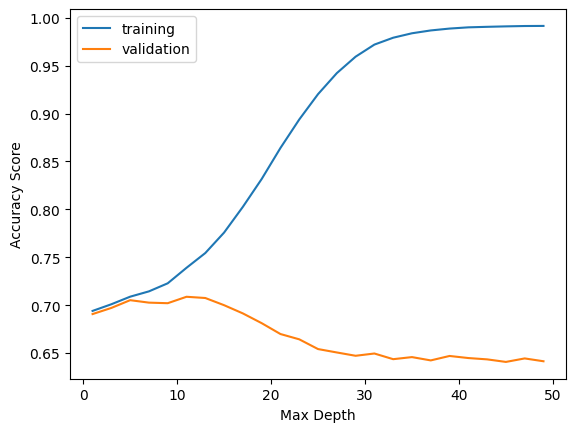

In [ ]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

In [ ]:
# Build Model
model = make_pipeline(
   OrdinalEncoder(),
   DecisionTreeClassifier(max_depth=7, random_state=42))

# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
Building with Central Courtyard     8
Others                              9
H-shape                            10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': adobe mud               1
mud mortar ,stone       2
rc non engineered       3
mud mortar brick        4
bamboo                  5
timber                  6
rc engineered           7
cement mortar brick     8
other                   9
stone flag             10
cement mortar stone    11
NaN                    -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=7, random_state=42))])

## Evaluate

In [ ]:
test_acc = model.score(X_test, y_test)
print("Test Accuracy:", round(test_acc, 2))

Test Accuracy: 0.71


# Results

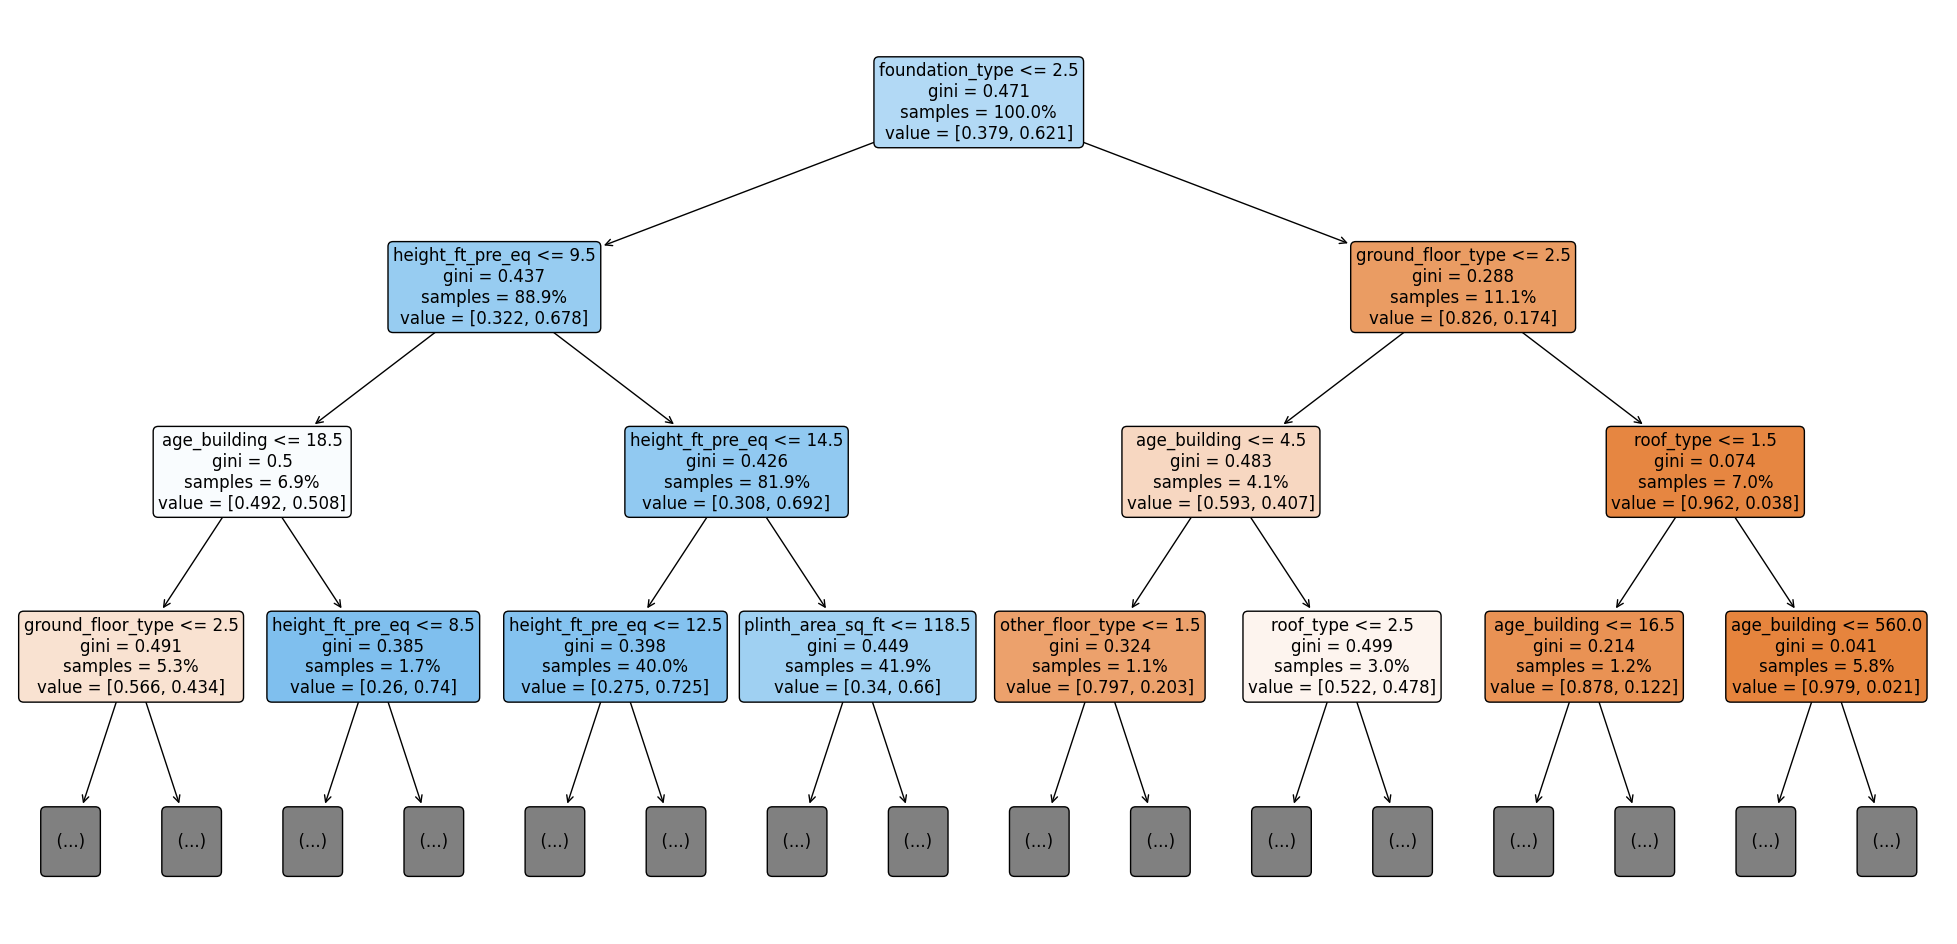

In [ ]:
# Use the plot_tree function from scikit-learn to visualize the decision logic of our model

# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
     decision_tree= model.named_steps["decisiontreeclassifier"],
     feature_names= X_train.columns,
     filled=True, # Color leaf with class
     rounded=True, # Round leaf edges
     proportion=True, # Display proportion of classes in leaf
     max_depth=3, # Only display first 3 levels
     fontsize=12, # Enlarge font
     ax=ax, # Place in figure axis
);

In [ ]:
# Assign the feature names and importances of our model to a variables

features = X_train.columns
importances = model.named_steps["decisiontreeclassifier"].feature_importances_
print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq'], dtype='object')
Importances: [0.06741875 0.0389286  0.10489015]


In [ ]:
# Create a pandas Series named feat_imp, where the index is features and the values are our importances

feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.head()

position                  0.001048
superstructure            0.004178
plan_configuration        0.005541
roof_type                 0.015447
land_surface_condition    0.016473
dtype: float64

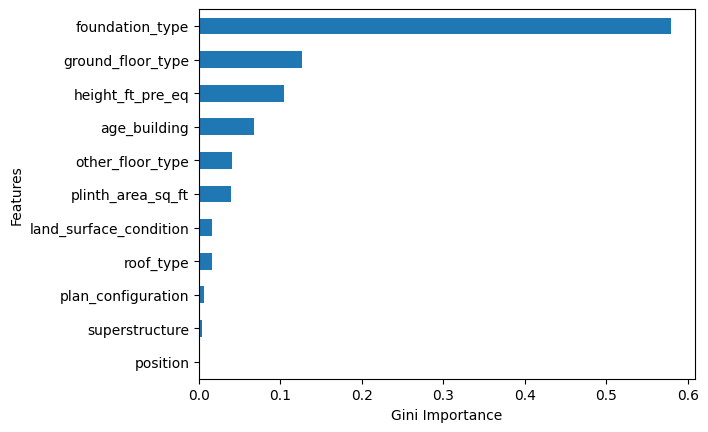

In [ ]:
# Create horizontal bar chart with all the features in feat_imp
feat_imp.plot(kind= "barh")
plt.xlabel("Gini Importance")
plt.ylabel("Features");